# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [82]:
import pandas as pd
import numpy as np

#### Loading the data

In [83]:
# changed header=None to header=0, so that it automatically assigns the column names
data = pd.read_csv("adult.csv", header=0, na_values='?')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Removing NaN values and convert categorical columns to catagory datatype

In [84]:
data = data.dropna()

In [85]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation',
                      'relationship', 'race', 'sex', 'native-country', 'salary']

for column in categorical_features:
    data[column] = data[column].astype('category')

#### Encoding the target variable (salary)

In [86]:
# unique salary entries before encoding target variable (expect <=50k & >50k)
unique_salary = data['salary'].unique()
print(unique_salary)

['<=50K', '>50K', '<=50K.', '>50K.']
Categories (4, object): ['<=50K', '<=50K.', '>50K', '>50K.']


In [87]:
# encoding the target variable
salary_mapping = {'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1}
data['salary'] = data['salary'].map(salary_mapping)

#### Checking if encoding went well

In [88]:
# unique salary entries after encoding target variable (expect 0 & 1)
unique_salary = data['salary'].unique()
print(unique_salary)

[0 1]


In [89]:
# these rows display encoded salary with 0 and 1 (data.head() only shows first 5 which are all 0)
data.iloc[4:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

#### Preprocessing choices

For now I have:
- MinMaxScaler() -> numerical columns
- OneHotEncoder() -> categorical columns

Not used:
- Imputer() -> because we have already removed all of the NaN values (?)

#### Extracting numerical & categorical columns for next step

In [90]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).drop(['salary'], axis=1).columns
categorical_features = data.select_dtypes(include=['category']).columns

# Print confirmation of all columns
print("Numeric Features:")
for col in numeric_features:
    print(f"  - {col}")

print("\nCategorical Features:")
for col in categorical_features:
    print(f"  - {col}")

Numeric Features:
  - age
  - fnlwgt
  - education-num
  - capital-gain
  - capital-loss
  - hours-per-week

Categorical Features:
  - workclass
  - education
  - marital-status
  - occupation
  - relationship
  - race
  - sex
  - native-country


In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Define your preprocessing steps here (discuss if a pipeline is necessary here)
numerical_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# show the correlation between different features including target variable
def visualize(data, ct):
    pass

# apply your model to feature array X and labels y
def apply_model(model, X, y):
    # wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # evaluate the model and store results
    return evaluate_model(X, y, pipeline)

def evaluate_model(X, y, pipeline):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report

### Performing the classification using 4 random classifiers
#### (may take 1-2 minutes to perform this step and gives an warning, but for now lets run with it)

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# split data into features and target variable
X = data.drop(columns='salary')
y = data['salary']

results_lr = apply_model(LogisticRegression(max_iter=500), X, y) 
results_rf = apply_model(RandomForestClassifier(n_estimators=100, n_jobs=-1), X, y) # takes ages without these parameters
results_svc = apply_model(SVC(C=1, kernel='linear', verbose=False, max_iter=1000), X, y) # takes ages without these parameters
results_knn = apply_model(KNeighborsClassifier(), X, y)

# Print accuracy results for each model to see if it worked
print("Logistic Regression Results:", results_lr[0])
print("Random Forest Results:", results_rf[0])
print("SVC Results:", results_svc[0])
print("KNN Results:", results_knn[0])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Logistic Regression Results: 0.8501934770591487
Random Forest Results: 0.8560530679933664
SVC Results: 0.48899944720840244
KNN Results: 0.8200110558319513


### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [115]:
def perturbate(y, fraction):
    y_array = y.to_numpy()  # Convert to numpy array

    # Determine the number of labels to flip
    n_flips = int(len(y_array) * fraction)

    # Randomly select indices to flip
    indices_to_flip = np.random.choice(len(y_array), size=n_flips, replace=False)

    # Flip the labels (assuming binary classification with labels 0 and 1)
    y_array[indices_to_flip] = 1 - y_array[indices_to_flip]

    return y_array

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

#### Create Perturbed Datasets

In [116]:
def create_perturbed_datasets(y, increment=0.1, max_fraction=0.5):
    perturbed_datasets = {}
    fractions = np.arange(0, max_fraction + increment, increment)
    
    for fraction in fractions:
        perturbed_y = perturbate(y, fraction)
        perturbed_datasets[fraction] = perturbed_y
        
    return perturbed_datasets

perturbed_datasets = create_perturbed_datasets(y)
len(perturbed_datasets)

6

#### Evaluate Models (takes some time)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1),
    'SVC': SVC(C=1, kernel='linear', verbose=False, max_iter=1000),
    'KNN': KNeighborsClassifier()
}

def evaluate_models_on_perturbed_data(models, perturbed_datasets, X, y, n_runs=1):
    results = {}
    
    for fraction, perturbed_y in perturbed_datasets.items():
        results[fraction] = {}
        
        for model_name, model in models.items():
            scores = []
            for _ in range(n_runs):
                score = apply_model(model, X, perturbed_y)
                scores.append(score[0])  # Access the accuracy from the tuple
            
            results[fraction][model_name] = {
                'mean_accuracy': np.mean(scores),
                'variance': np.var(scores)
            }
    
    return results


results = evaluate_models_on_perturbed_data(models, perturbed_datasets, X, y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#### Visualizing results

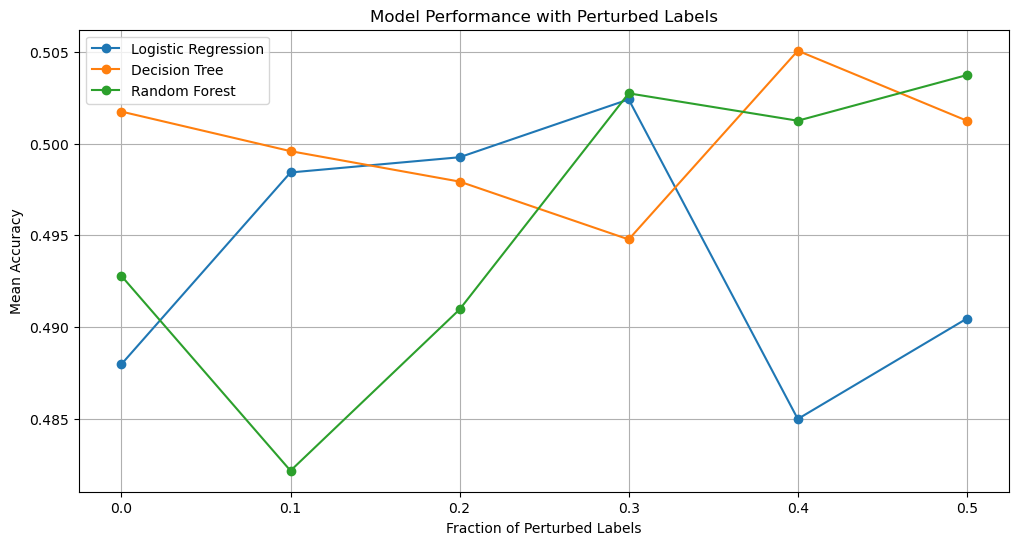

In [133]:
def plot_results(results):
    plt.figure(figsize=(12, 6))
    
    for model_name in models.keys():
        means = []
        for fraction in sorted(results.keys()):
            means.append(results[fraction][model_name]['mean_accuracy'])
        
        plt.plot(sorted(results.keys()), means, marker='o', label=model_name)
        
    plt.title('Model Performance with Perturbed Labels')
    plt.xlabel('Fraction of Perturbed Labels')
    plt.ylabel('Mean Accuracy')
    plt.xticks(sorted(results.keys()))
    plt.legend()
    plt.grid()
    plt.show()
    
plot_results(results)

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

Now we have a some datasets that are related to each other.

**Altogether they are the same as the adult dataset used in the part 1 of the assignment.**

In this scenario, one can see the utility of the subsets of data can impact the outcome of the task from the previous section.

Because the data is split up, we want to be able to re-construct the data through data discovery.

As data discovery will allow you to be able to find relations that can be used to reconstruct the entire dataset.

Implement a method of your choice to perform the data discovery to be able to recover the entire dataset from part 1 of the assignment.

In [ ]:
def discovery_algorithm():
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """

    pass

In [ ]:
## Do some testing using different degrees of relations on the downstream task.
##



### Evaluation

Following the same workflow as Part 1 of the assignment, you will need to perform the steps once again.
This means that with the difference in setting, there has now been a change in the data loading portion of the workflow. 

<!-- While performing data discovery, one can check how having more data of different relations can effect the outcome of the downstream task. -->

As you perform the act of data discovery you will be piecing the data back together one by one by finding the relation between the datasets.

As you piece the data back together, the entire dataset will be available in varying portions.

Then using the different portions of available data, fit the models that were used previously, and examine the results when testing on the appropriate data from the testing samples.

*The dataset from part 1 can be treated as the groundtruth, so you can try and random sample from that dataset to produce the testing samples that can be used in this part.* 

***

One can also evaluate on the effect of incorrectness of data discovery.

Suppose what you have done for data discovery is correct, this means the relations that are found are correct.

What if you perform a perturbation on the relations between the files? 

This would mean the dataset will be incorrectly joined, do you think there will be an impact on the outcome of the model that will be trained and then tested on the groudtruth dataset?

What would the effect be on the downstream tasks as mentioned in the machine learning workflow such as data pre-processing, machine learning model training and testing?

This can be evaluated in the same way as above.

In [ ]:
## Do some testing on performing various degrees of incorrect data discovery.
##

## Discussions

1)  Discuss the different effects of the results of the data discovery results on various downstream tasks in the machine learning workflow.
    As stated previously, this is effecting the data loading portion of the ML workflow.

2)  Discuss also what aspects need to be considered when performing data discovery and evaluating the results of data discovery.

Max. 400 words

The perturbations that performed for part 1 and 2 are all data quality issues.

3) Discuss on the effects of data quality and how you may attempt to identify and solve these issues?

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words